In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.utils import shuffle

import re

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from textblob import TextBlob
from nltk import tokenize

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\toppi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\toppi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\toppi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\toppi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
df = pd.read_csv('sample_data/reddit_wsb.csv')
df.head()

title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4  Not to distract from GME, just thought our AMC...     71  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.redd.it/4h2sukb662e61.jpg        156  1.611862e+09   

                                                body            timestamp  
0                                                NaN  2021-01-28 21:37:41  
1                                                NaN  2021-01-28 21:32:10  
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35  
3                                                NaN  2021-01-28 21:28:57  
4                                                NaN  2021-01-28 21:26:56

In [5]:
df.drop_duplicates(subset ="title", keep = "first", inplace = True)

In [6]:
df.shape

(49236, 8)

In [7]:
df['title'] = df['title'].astype('str')

In [8]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity


df['Polarity'] = df['title'].apply(get_polarity)

In [9]:
df['Sentiment_Type']=''
df.loc[df.Polarity>0,'Sentiment_Type']='POSITIVE'
df.loc[df.Polarity==0,'Sentiment_Type']='NEUTRAL'
df.loc[df.Polarity<0,'Sentiment_Type']='NEGATIVE'

In [10]:
df['Sentiment_Type'].value_counts()

NEUTRAL     28107
POSITIVE    12273
NEGATIVE     8856
Name: Sentiment_Type, dtype: int64

In [11]:
df.Sentiment_Type.value_counts().plot(kind='bar',title="Sentiment Analysis")

<AxesSubplot:title={'center':'Sentiment Analysis'}>

In [12]:
# Apply first level cleaning
import re
import string

#This function converts to lower-case, removes square bracket, removes numbers and punctuation
def text_clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

cleaned = lambda x: text_clean(x)

In [13]:
# Let's take a look at the updated text
df['title'] = pd.DataFrame(df.title.apply(cleaned))
df.head(10)

title  score      id  \
0  its not about the money its about sending a me...     55  l6ulcx   
1  math professor scott steiner says the numbers ...    110  l6uibd   
2                                    exit the system      0  l6uhhn   
3  new sec filing for gme can someone less retard...     29  l6ugk6   
4  not to distract from gme just thought our amc ...     71  l6ufgy   
5                                we breaking through    405  l6uf7d   
6         short stock doesnt have an expiration date    317  l6uf6d   
7                                 this is the moment    405  l6ub9l   
8  currently holding amc and nok  is it retarded ...    200  l6ub4i   
9  i have nothing to say but bruh i am speechless...    291  l6uas9   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.redd.it/4h2sukb662e61.jpg        156  1.611862e+09   
5                https://i.redd.it/2wef8tc062e61.png         84  1.611862e+09   
6  https://www.reddit.com/r/wallstreetbets/commen...         53  1.611862e+09   
7  https://www.reddit.com/r/wallstreetbets/commen...        178  1.611862e+09   
8                https://i.redd.it/6k2z7ouo42e61.png        161  1.611862e+09   
9                https://i.redd.it/bfzzw2yo42e61.jpg         27  1.611862e+09   

                                                body            timestamp  \
0                                                NaN  2021-01-28 21:37:41   
1                                                NaN  2021-01-28 21:32:10   
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35   
3                                                NaN  2021-01-28 21:28:57   
4                                                NaN  2021-01-28 21:26:56   
5                                                NaN  2021-01-28 21:26:30   
6  Hedgefund whales are spreading disinfo saying ...  2021-01-28 21:26:27   
7  Life isn't fair. My mother always told me that...  2021-01-28 21:19:31   
8                                                NaN  2021-01-28 21:19:16   
9                                                NaN  2021-01-28 21:18:37   

   Polarity Sentiment_Type  
0  0.000000        NEUTRAL  
1  0.000000        NEUTRAL  
2  0.000000        NEUTRAL  
3 -0.238826       NEGATIVE  
4  0.250000       POSITIVE  
5  0.000000        NEUTRAL  
6  0.000000        NEUTRAL  
7  0.000000        NEUTRAL  
8 -0.400000       NEGATIVE  
9  0.000000        NEUTRAL

In [14]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\toppi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
df['score'] = df['title'].apply(lambda title: sid.polarity_scores(title))

df.head()

title  \
0  its not about the money its about sending a me...   
1  math professor scott steiner says the numbers ...   
2                                    exit the system   
3  new sec filing for gme can someone less retard...   
4  not to distract from gme just thought our amc ...   

                                               score      id  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l6ulcx   
1  {'neg': 0.272, 'neu': 0.728, 'pos': 0.0, 'comp...  l6uibd   
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l6uhhn   
3  {'neg': 0.204, 'neu': 0.658, 'pos': 0.138, 'co...  l6ugk6   
4  {'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'comp...  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.redd.it/4h2sukb662e61.jpg        156  1.611862e+09   

                                                body            timestamp  \
0                                                NaN  2021-01-28 21:37:41   
1                                                NaN  2021-01-28 21:32:10   
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35   
3                                                NaN  2021-01-28 21:28:57   
4                                                NaN  2021-01-28 21:26:56   

   Polarity Sentiment_Type  
0  0.000000        NEUTRAL  
1  0.000000        NEUTRAL  
2  0.000000        NEUTRAL  
3 -0.238826       NEGATIVE  
4  0.250000       POSITIVE

In [16]:
df['compound']  = df['score'].apply(lambda score_dict: score_dict['compound'])

#df.head()

In [17]:
df['sentiment_type']=''
df.loc[df.compound>0,'sentiment_type']='POSITIVE'
df.loc[df.compound==0,'sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'sentiment_type']='NEGATIVE'

In [18]:
df.head()

title  \
0  its not about the money its about sending a me...   
1  math professor scott steiner says the numbers ...   
2                                    exit the system   
3  new sec filing for gme can someone less retard...   
4  not to distract from gme just thought our amc ...   

                                               score      id  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l6ulcx   
1  {'neg': 0.272, 'neu': 0.728, 'pos': 0.0, 'comp...  l6uibd   
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l6uhhn   
3  {'neg': 0.204, 'neu': 0.658, 'pos': 0.138, 'co...  l6ugk6   
4  {'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'comp...  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.redd.it/4h2sukb662e61.jpg        156  1.611862e+09   

                                                body            timestamp  \
0                                                NaN  2021-01-28 21:37:41   
1                                                NaN  2021-01-28 21:32:10   
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35   
3                                                NaN  2021-01-28 21:28:57   
4                                                NaN  2021-01-28 21:26:56   

   Polarity Sentiment_Type  compound sentiment_type  
0  0.000000        NEUTRAL    0.0000        NEUTRAL  
1  0.000000        NEUTRAL   -0.6249       NEGATIVE  
2  0.000000        NEUTRAL    0.0000        NEUTRAL  
3 -0.238826       NEGATIVE   -0.2748       NEGATIVE  
4  0.250000       POSITIVE    0.2235       POSITIVE

In [19]:
df['sentiment_type'].value_counts()

NEUTRAL     22382
POSITIVE    15737
NEGATIVE    11117
Name: sentiment_type, dtype: int64

<AxesSubplot:title={'center':'sentiment analysis'}>

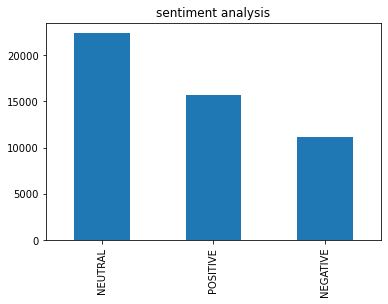

In [20]:
df.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")

In [21]:
df[df['sentiment_type'] == 'NEGATIVE'].head()

title  \
1   math professor scott steiner says the numbers ...   
3   new sec filing for gme can someone less retard...   
8   currently holding amc and nok  is it retarded ...   
18     words brought to you by the fuckers at the sec   
21  we need to stick together and 💎🖐 the ever lovi...   

                                                score      id  \
1   {'neg': 0.272, 'neu': 0.728, 'pos': 0.0, 'comp...  l6uibd   
3   {'neg': 0.204, 'neu': 0.658, 'pos': 0.138, 'co...  l6ugk6   
8   {'neg': 0.188, 'neu': 0.812, 'pos': 0.0, 'comp...  l6ub4i   
18  {'neg': 0.302, 'neu': 0.698, 'pos': 0.0, 'comp...  l6u2x7   
21  {'neg': 0.224, 'neu': 0.672, 'pos': 0.104, 'co...  l6two5   

                                                  url  comms_num  \
1                     https://v.redd.it/ah50lyny62e61         23   
3   https://sec.report/Document/0001193125-21-019848/         74   
8                 https://i.redd.it/6k2z7ouo42e61.png        161   
18                https://i.redd.it/r4ja2vj922e61.jpg         41   
21  https://www.reddit.com/r/wallstreetbets/commen...        323   

         created                                               body  \
1   1.611862e+09                                                NaN   
3   1.611862e+09                                                NaN   
8   1.611862e+09                                                NaN   
18  1.611861e+09                                                NaN   
21  1.611860e+09  This is our time. If anyone will listen to you...   

              timestamp  Polarity Sentiment_Type  compound sentiment_type  
1   2021-01-28 21:32:10  0.000000        NEUTRAL   -0.6249       NEGATIVE  
3   2021-01-28 21:28:57 -0.238826       NEGATIVE   -0.2748       NEGATIVE  
8   2021-01-28 21:19:16 -0.400000       NEGATIVE   -0.5719       NEGATIVE  
18  2021-01-28 21:05:01 -0.100000       NEGATIVE   -0.5994       NEGATIVE  
21  2021-01-28 20:54:08 -0.490625       NEGATIVE   -0.4118       NEGATIVE

In [22]:
df[df['sentiment_type'] == 'POSITIVE'].head()

title  \
4   not to distract from gme just thought our amc ...   
11                 gme premarket 🍁 musk approved 🎮🛑💎✋   
14                                 i love you retards   
23     im so proud of how far this subreddit has come   
26        i’ve got a friend who is all in on gme 🚀💎🙌🏼   

                                                score      id  \
4   {'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'comp...  l6ufgy   
11  {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...  l6ua2q   
14  {'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'comp...  l6u8hc   
23  {'neg': 0.0, 'neu': 0.726, 'pos': 0.274, 'comp...  l6tuae   
26  {'neg': 0.0, 'neu': 0.738, 'pos': 0.262, 'comp...  l6tsx4   

                                                  url  comms_num  \
4                 https://i.redd.it/4h2sukb662e61.jpg        156   
11                https://i.redd.it/48rmgz5c42e61.png         97   
14              https://www.reddit.com/gallery/l6u8hc         32   
23  https://www.reddit.com/r/wallstreetbets/commen...         89   
26                https://i.redd.it/hgrgffo1z1e61.jpg         43   

         created                                               body  \
4   1.611862e+09                                                NaN   
11  1.611861e+09                                                NaN   
14  1.611861e+09                                                NaN   
23  1.611860e+09  I still remember when I first joined and most ...   
26  1.611860e+09                                                NaN   

              timestamp  Polarity Sentiment_Type  compound sentiment_type  
4   2021-01-28 21:26:56      0.25       POSITIVE    0.2235       POSITIVE  
11  2021-01-28 21:17:28      0.00        NEUTRAL    0.4215       POSITIVE  
14  2021-01-28 21:14:44     -0.25       NEGATIVE    0.6369       POSITIVE  
23  2021-01-28 20:49:39      0.45       POSITIVE    0.5256       POSITIVE  
26  2021-01-28 20:46:58      0.00        NEUTRAL    0.4939       POSITIVE

In [23]:
df[df['sentiment_type'] == 'NEUTRAL'].head()

title  \
0  its not about the money its about sending a me...   
2                                    exit the system   
5                                we breaking through   
6         short stock doesnt have an expiration date   
7                                 this is the moment   

                                               score      id  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l6ulcx   
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l6uhhn   
5  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l6uf7d   
6  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l6uf6d   
7  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l6ub9l   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
5                https://i.redd.it/2wef8tc062e61.png         84  1.611862e+09   
6  https://www.reddit.com/r/wallstreetbets/commen...         53  1.611862e+09   
7  https://www.reddit.com/r/wallstreetbets/commen...        178  1.611862e+09   

                                                body            timestamp  \
0                                                NaN  2021-01-28 21:37:41   
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35   
5                                                NaN  2021-01-28 21:26:30   
6  Hedgefund whales are spreading disinfo saying ...  2021-01-28 21:26:27   
7  Life isn't fair. My mother always told me that...  2021-01-28 21:19:31   

   Polarity Sentiment_Type  compound sentiment_type  
0       0.0        NEUTRAL       0.0        NEUTRAL  
2       0.0        NEUTRAL       0.0        NEUTRAL  
5       0.0        NEUTRAL       0.0        NEUTRAL  
6       0.0        NEUTRAL       0.0        NEUTRAL  
7       0.0        NEUTRAL       0.0        NEUTRAL

In [24]:
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [25]:
df['sentiment_type'].value_counts()

NEUTRAL     22382
POSITIVE    15737
NEGATIVE    11117
Name: sentiment_type, dtype: int64

In [26]:
df = df[pd.notnull(df['sentiment_type'])]
df = df.sample(frac=0.5, random_state=99).reset_index(drop=True)
df = shuffle(df, random_state=22)
df = df.reset_index(drop=True)
df['class_label'] = df['sentiment_type'].factorize()[0]
class_label_df = df[['sentiment_type', 'class_label']].drop_duplicates().sort_values('class_label')
label_to_id = dict(class_label_df.values)
id_to_label = dict(class_label_df[['class_label', 'sentiment_type']].values)

In [27]:
df.head(10)

title  \
0                          could this be the squeeze   
1           robinhood blocking users from buying gme   
2           what is a good replacement for robinhood   
3  wall street journal  what a respectable source...   
4               cashapp is letting you buy amc again   
5  amat dd and why semiconductor stocks are a gre...   
6  i never knew it was possible to lose this much...   
7  comprehensive list of alternative trading plat...   
8  yolo on the ugly stepsister of gme and meme st...   
9  how long did it take you to become less riskav...   

                                               score      id  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l6yxxr   
1  {'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'comp...  l6zjqk   
2  {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...  l72hhi   
3  {'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp...  lbqtuh   
4  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l720kp   
5  {'neg': 0.0, 'neu': 0.581, 'pos': 0.419, 'comp...  nwnysp   
6  {'neg': 0.151, 'neu': 0.726, 'pos': 0.123, 'co...  lhxnp2   
7  {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'comp...  l6wxzz   
8  {'neg': 0.246, 'neu': 0.597, 'pos': 0.157, 'co...  m3rhm7   
9  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  n7us6r   

                                                 url  comms_num       created  \
0  https://www.reddit.com/r/wallstreetbets/commen...          1  1.611875e+09   
1                https://i.redd.it/974cspwdc3e61.jpg          0  1.611876e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...          5  1.611882e+09   
3                https://i.redd.it/s0s3z9w6daf61.jpg          9  1.612397e+09   
4  https://www.reddit.com/r/wallstreetbets/commen...          1  1.611881e+09   
5  https://www.reddit.com/r/wallstreetbets/commen...         15  1.623361e+09   
6                https://i.redd.it/48oihdoblxg61.jpg        375  1.613114e+09   
7  https://www.reddit.com/r/wallstreetbets/commen...          1  1.611870e+09   
8                https://i.redd.it/28st8fhhznm61.jpg         12  1.615613e+09   
9  https://www.reddit.com/r/wallstreetbets/commen...        137  1.620526e+09   

                                                body            timestamp  \
0  Maybe I’m crazy but could this Robinhood shutd...  2021-01-29 01:03:02   
1                                                NaN  2021-01-29 01:23:32   
2  After today there's no way I want them around ...  2021-01-29 03:05:45   
3                                                NaN  2021-02-04 02:04:38   
4                                                NaN  2021-01-29 02:50:16   
5  As usual for me, I took some of my adderall pr...  2021-06-11 00:42:20   
6                                                NaN  2021-02-12 09:15:20   
7  Please try to get this to the top, and post ev...  2021-01-28 23:45:19   
8                                                NaN  2021-03-13 07:21:42   
9  I’m totally new to the investing/trading game,...  2021-05-09 05:01:56   

   Polarity Sentiment_Type  compound sentiment_type  class_label  
0  0.000000        NEUTRAL    0.0000        NEUTRAL            0  
1  0.000000        NEUTRAL   -0.3818       NEGATIVE            1  
2  0.700000       POSITIVE    0.4404       POSITIVE            2  
3  0.433333       POSITIVE    0.7003       POSITIVE            2  
4  0.000000        NEUTRAL    0.0000        NEUTRAL            0  
5  0.542857       POSITIVE    0.7579       POSITIVE            2  
6  0.100000       POSITIVE   -0.1280       NEGATIVE            1  
7  0.000000        NEUTRAL    0.2500       POSITIVE            2  
8 -0.700000       NEGATIVE   -0.2960       NEGATIVE            1  
9 -0.108333       NEGATIVE    0.0000        NEUTRAL            0

In [28]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
   # text = BeautifulSoup(text, "lxml").text # HTML decoding. BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
df['title'] = df['title'].apply(clean_text)

In [29]:
df['class_label'].value_counts()

0    11230
2     7849
1     5539
Name: class_label, dtype: int64

In [30]:
df.head()

title  \
0                                      could squeeze   
1                robinhood blocking users buying gme   
2                         good replacement robinhood   
3  wall street journal respectable source news gm...   
4                            cashapp letting buy amc   

                                               score      id  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l6yxxr   
1  {'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'comp...  l6zjqk   
2  {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...  l72hhi   
3  {'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp...  lbqtuh   
4  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  l720kp   

                                                 url  comms_num       created  \
0  https://www.reddit.com/r/wallstreetbets/commen...          1  1.611875e+09   
1                https://i.redd.it/974cspwdc3e61.jpg          0  1.611876e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...          5  1.611882e+09   
3                https://i.redd.it/s0s3z9w6daf61.jpg          9  1.612397e+09   
4  https://www.reddit.com/r/wallstreetbets/commen...          1  1.611881e+09   

                                                body            timestamp  \
0  Maybe I’m crazy but could this Robinhood shutd...  2021-01-29 01:03:02   
1                                                NaN  2021-01-29 01:23:32   
2  After today there's no way I want them around ...  2021-01-29 03:05:45   
3                                                NaN  2021-02-04 02:04:38   
4                                                NaN  2021-01-29 02:50:16   

   Polarity Sentiment_Type  compound sentiment_type  class_label  
0  0.000000        NEUTRAL    0.0000        NEUTRAL            0  
1  0.000000        NEUTRAL   -0.3818       NEGATIVE            1  
2  0.700000       POSITIVE    0.4404       POSITIVE            2  
3  0.433333       POSITIVE    0.7003       POSITIVE            2  
4  0.000000        NEUTRAL    0.0000        NEUTRAL            0

In [31]:
list_corpus = df["title"].tolist()
list_labels = df["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 3), stop_words = 'english', binary=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [32]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors, y_train)

C:\Users\toppi\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100000.0, n_jobs=1)

In [33]:
pred = logreg.predict(test_vectors)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.819, precision = 0.817, recall = 0.819, f1 = 0.816


In [34]:
c = make_pipeline(vectorizer, logreg)
class_names=list(df.title.unique())
explainer = LimeTextExplainer(class_names=class_names)

In [35]:
class_names

['could squeeze',
 'robinhood blocking users buying gme',
 'good replacement robinhood',
 'wall street journal respectable source news gme sheds nearly good one',
 'cashapp letting buy amc',
 'amat dd semiconductor stocks great play right',
 'never knew possible lose much one day shares',
 'comprehensive list alternative trading platforms',
 'yolo ugly stepsister gme meme stocks',
 'long take become less riskaverse',
 'gme causing chain effect internationally everywhere',
 'hear short everything',
 'finally found pathway true change going guys',
 'added',
 'round go',
 'boys holding gme norway lets gooo buy fucking hold dipshits',
 'honestly whats wrong ge',
 'thanks sec knew cared notification rh',
 'risk tolerance exercise everyone gme',
 'current state gme',
 'amc short interest',
 'dont know happening point im afraid ask',
 'yolo account ready',
 'gamestop cfo resigns following meme stock frenzy',
 'updated picture hope works',
 'cant another gme michael burry',
 'could udeepfuckin

In [36]:
idx = 1877
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, labels=[0, 1])
print('Document id: %d' % idx)
print('Predicted class =', class_names[logreg.predict(test_vectors[idx]).reshape(1,-1)[0,0]])
print('True class: %s' % class_names[y_test[idx]])

Document id: 1877
Predicted class = robinhood blocking users buying gme
True class: robinhood blocking users buying gme


In [37]:
print ('Explanation for class %s' % class_names[0])
print ('\n'.join(map(str, exp.as_list(label=1))))

Explanation for class could squeeze
('rigged', 0.6058238567642832)
('frenzy', 0.34998638071951055)
('street', -0.15229654611318447)
('says', -0.14843716331279366)
('warren', -0.09691448894217722)
('wall', -0.0774627893831521)


In [38]:
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, top_labels=2)
print(exp.available_labels())

[1, 0]


In [39]:
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras.preprocessing import text



In [40]:
tags_split = [tags.split(',') for tags in df['title'].values]
print(tags_split[:10])

[['could squeeze'], ['robinhood blocking users buying gme'], ['good replacement robinhood'], ['wall street journal respectable source news gme sheds nearly good one'], ['cashapp letting buy amc'], ['amat dd semiconductor stocks great play right'], ['never knew possible lose much one day shares'], ['comprehensive list alternative trading platforms'], ['yolo ugly stepsister gme meme stocks'], ['long take become less riskaverse']]


In [41]:
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(df['title'].values[0])
print(tag_encoder.classes_)
print(tags_encoded[0])

could squeeze
['' 'aa pre market' 'aaaaaall abooooaaaard' ... 'zrx next buy buy'
 'zubu client sentiment report market recap' 'zuo finally moon']
[0 0 0 ... 0 0 0]


In [42]:
train_size = int(len(df) * .8)
print('train size: %d' % train_size)
print('test size: %d' % (len(df) - train_size))

train size: 19694
test size: 4924


In [43]:
y_train = tags_encoded[: train_size]
y_test = tags_encoded[train_size:]

In [44]:
class TextPreprocessor(object):
    def __init__(self, vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None
    def create_tokenizer(self, text_list):
        tokenizer = text.Tokenizer(num_words = self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer
    def transform_text(self, text_list):
        text_matrix = self._tokenizer.texts_to_matrix(text_list)
        return text_matrix

In [45]:
VOCAB_SIZE = 500
train_post = df['title'].values[: train_size]
test_post = df['title'].values[train_size: ]
processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_post)
X_train = processor.transform_text(train_post)
X_test = processor.transform_text(test_post)

In [46]:
print(len(X_train[0]))
print(X_train[0])

500
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [47]:
def create_model(vocab_size, num_tags):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(50, input_shape = (VOCAB_SIZE,), activation='relu'))
    model.add(tf.keras.layers.Dense(25, activation='relu'))
    model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model
model = create_model(VOCAB_SIZE, num_tags)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                25050     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 23388)             608088    
Total params: 634,413
Trainable params: 634,413
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.fit(X_train, y_train, epochs = 15, batch_size=128, validation_split=0.1)
print('Eval loss/accuracy:{}'.format(model.evaluate(X_test, y_test, batch_size = 128)))

Epoch 1/15
139/139 [==============================] - 18s 124ms/step - loss: 0.2929 - accuracy: 5.6421e-05 - val_loss: 0.0114 - val_accuracy: 0.0000e+00
Epoch 2/15
139/139 [==============================] - 16s 114ms/step - loss: 0.0048 - accuracy: 0.0031 - val_loss: 0.0022 - val_accuracy: 0.0041
Epoch 3/15
139/139 [==============================] - 16s 116ms/step - loss: 0.0015 - accuracy: 0.0054 - val_loss: 0.0012 - val_accuracy: 0.0041
Epoch 4/15
139/139 [==============================] - 14s 102ms/step - loss: 9.6324e-04 - accuracy: 0.0054 - val_loss: 8.7980e-04 - val_accuracy: 0.0041
Epoch 5/15
139/139 [==============================] - 16s 118ms/step - loss: 7.9961e-04 - accuracy: 0.0054 - val_loss: 7.7768e-04 - val_accuracy: 0.0041
Epoch 6/15
139/139 [==============================] - 15s 105ms/step - loss: 7.2895e-04 - accuracy: 0.0054 - val_loss: 7.2751e-04 - val_accuracy: 0.0041
Epoch 7/15
139/139 [==============================] - 16s 116ms/step - loss: 6.8794e-04 - accuracy

In [49]:
# Installs latest version of TensorFlow 2.X 
!pip install --upgrade tensorflow

  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached keras_nightly-2.5.0.dev2021032900-py2.py3-none-any.whl (1.2 MB)
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_auth_oauthlib-0.4.4-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached rsa-4.7.2-py3-none-any.whl (34 kB)
  Using cached cachetools-4.2.2-py3-none-any.whl (11 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 

In [51]:
import shap
import tensorflow as tf

In [52]:
import tensorflow.python.keras.backend as K
sess = K.get_session()

In [53]:
attrib_data = X_train[:200]
explainer = shap.DeepExplainer(model, attrib_data)
num_explanations = 40
shap_vals = explainer.shap_values(X_test[:num_explanations])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


KeyboardInterrupt: 

In [ ]:
words = processor._tokenizer.word_index
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)

In [ ]:
# could not get shap to run maybe too much data?

In [54]:
# Import our dependencies
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [55]:
df1 = pd.read_csv(Path('sample_data/AAPL.csv'))
df1.head()

Date       Low      Open     Volume      High     Close  \
0  12-12-1980  0.128348  0.128348  469033600  0.128906  0.128348   
1  15-12-1980  0.121652  0.122210  175884800  0.122210  0.121652   
2  16-12-1980  0.112723  0.113281  105728000  0.113281  0.112723   
3  17-12-1980  0.115513  0.115513   86441600  0.116071  0.115513   
4  18-12-1980  0.118862  0.118862   73449600  0.119420  0.118862   

   Adjusted Close  
0        0.100751  
1        0.095495  
2        0.088485  
3        0.090676  
4        0.093304

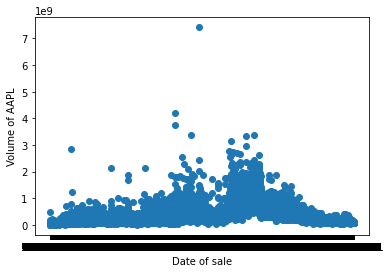

In [58]:
plt.scatter(df1.Date, df1.Volume)
plt.xlabel('Date of sale')
plt.ylabel('Volume of AAPL')
plt.show()

In [59]:
X = df1.Date.values.reshape(-1, 1)

In [60]:
X[:5]

array([['12-12-1980'],
       ['15-12-1980'],
       ['16-12-1980'],
       ['17-12-1980'],
       ['18-12-1980']], dtype=object)

In [61]:
X.shape

(10211, 1)

In [62]:
y = df1.Volume

In [63]:
model = LinearRegression()

In [64]:
model.fit(X, y)

ValueError: could not convert string to float: '12-12-1980'